In [217]:
from processing_functions import *
%matplotlib inline

In [218]:
# reading datasets
personal_data = pd.read_csv('./dataset/Ovarian/ovar_data_mar22_d032222.csv')
screen_data = pd.read_csv('./dataset/Ovarian/Screening/ovar_screen_data_mar22_d032222.csv')
screen_abnorm_data = pd.read_csv('./dataset/Ovarian/Screening Abnormalities/ovar_scrsub_data_mar22_d032222.csv')

In [219]:
personal_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78209 entries, 0 to 78208
Columns: 242 entries, ovar_reasfoll to in_TGWAS_population
dtypes: float64(191), int64(48), object(3)
memory usage: 144.4+ MB


In [220]:
personal_data.head()

,ovar_reasfoll,ovar_reassurv,ovar_reassymp,ovar_reasoth,ovar_cancer,ovar_intstat_cat,ovar_annyr,ovar_cancer_site,ovar_stage,ovar_stage_7e,...,sex,age,agelevel,dual,reconsent_outcome,reconsent_outcome_days,fstcan_exitstat,fstcan_exitage,fstcan_exitdays,in_TGWAS_population
0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,...,2,74,3,0,5,5621,8,87,4672,1
1,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,...,2,63,1,0,1,4106,8,72,3386,1
2,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,...,2,59,0,0,1,5864,8,72,4969,1
3,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,...,2,57,0,0,1,4687,8,68,4106,1
4,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,...,2,62,1,0,2,6126,8,78,5573,1


In [221]:
# Drop build feature
personal_data = personal_data.drop(['build'], axis=1)

personal_data_nan_cols = [i for i in personal_data.columns if personal_data[i].isnull().any()]
personal_data_drop_features = [col for col in personal_data_nan_cols if col.startswith('ovar_')]
print(f'Number of features that are result of the cancer diagnosis: {len(personal_data_drop_features)}')

Number of features that are result of the cancer diagnosis: 36


In [222]:
def print_records_vs_unique(df, col, dataset_name):
    # Get unique IDs
    print(f"Num of records in {dataset_name} dataset: {len(df)}")
    print(f"Num of unique {col} in {dataset_name} dataset: {len(df[col].unique())}")

print_records_vs_unique(personal_data, 'plco_id', 'personal')
# Check the number of people with cancer
personal_data_cancer = personal_data[personal_data['ovar_cancer']==1]
print(f"Num of patients with cancer: {len(personal_data_cancer)}")
# Check the number of people without cancer
personal_data_no_cancer = personal_data[personal_data['ovar_cancer']==0]
print(f"Num of patients without cancer: {len(personal_data_no_cancer)}")

Num of records in personal dataset: 78209
Num of unique plco_id in personal dataset: 78209
Num of patients with cancer: 613
Num of patients without cancer: 77596


In [223]:
# get percentage values missing
def get_missing_values_cols(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                    'percent_missing': percent_missing})
    missing_value_df.sort_values('percent_missing', inplace=True)
    missing_value_df = missing_value_df[missing_value_df.percent_missing != 0]
    return missing_value_df
personal_data_missing_value = get_missing_values_cols(personal_data)
missing_90_or_more = personal_data_missing_value[personal_data_missing_value.percent_missing >= 90]
missing_50_or_more = personal_data_missing_value[personal_data_missing_value.percent_missing >= 50]

In [224]:
personal_data_missing_value.describe().T

,count,mean,std,min,25%,50%,75%,max
percent_missing,192.0,42.622026,38.383291,2.677441,3.349359,50.001918,69.834674,99.937347


In [225]:
missing_50_or_more

,column_name,percent_missing
ca125_result1,ca125_result1,50.001918
ca125_result0,ca125_result0,50.001918
tvu_result1,tvu_result1,50.001918
tvu_result0,tvu_result0,50.001918
tvu_result2,tvu_result2,50.001918
...,...,...
ovar_clinstage_t,ovar_clinstage_t,99.845286
ovar_clinstage_n,ovar_clinstage_n,99.850401
ovar_clinstage_7e,ovar_clinstage_7e,99.874695
ovar_clinstage,ovar_clinstage,99.881088


In [226]:
def print_records_vs_unique_for(df, col, dataset_name, on):
    print_records_vs_unique(df, col, dataset_name)
    # Look at unique IDs for each of the years of study for screen dataset
    for val in sorted(df[on].unique()):
        # Get unique IDs
        print_records_vs_unique(df[df[on] == val], col, f'{dataset_name}.{on}={val}')

print_records_vs_unique_for(screen_data, 'plco_id', 'screen', 'study_yr')

Num of records in screen dataset: 150993
Num of unique plco_id in screen dataset: 30849
Num of records in screen.study_yr=0 dataset: 28919
Num of unique plco_id in screen.study_yr=0 dataset: 28919
Num of records in screen.study_yr=1 dataset: 27607
Num of unique plco_id in screen.study_yr=1 dataset: 27607
Num of records in screen.study_yr=2 dataset: 26637
Num of unique plco_id in screen.study_yr=2 dataset: 26637
Num of records in screen.study_yr=3 dataset: 25459
Num of unique plco_id in screen.study_yr=3 dataset: 25459
Num of records in screen.study_yr=4 dataset: 20146
Num of unique plco_id in screen.study_yr=4 dataset: 20146
Num of records in screen.study_yr=5 dataset: 22225
Num of unique plco_id in screen.study_yr=5 dataset: 22225


In [227]:
personal_data_cancer[['plco_id', 'ovar_cancer_diagdays', 'fstcan_exitdays', 'ovar_exitdays']].describe().T

,count,mean,std,min,25%,50%,75%,max
ovar_cancer_diagdays,613.0,2751.973899,1751.601513,5.0,1213.0,2745.0,4137.0,6895.0
fstcan_exitdays,613.0,2512.432300,1596.348029,5.0,1068.0,2564.0,3826.0,5800.0
ovar_exitdays,613.0,2647.187602,1606.080617,5.0,1213.0,2745.0,3929.0,5804.0


In [228]:
len(personal_data_cancer[personal_data_cancer['ovar_cancer_diagdays']<5*365])

221

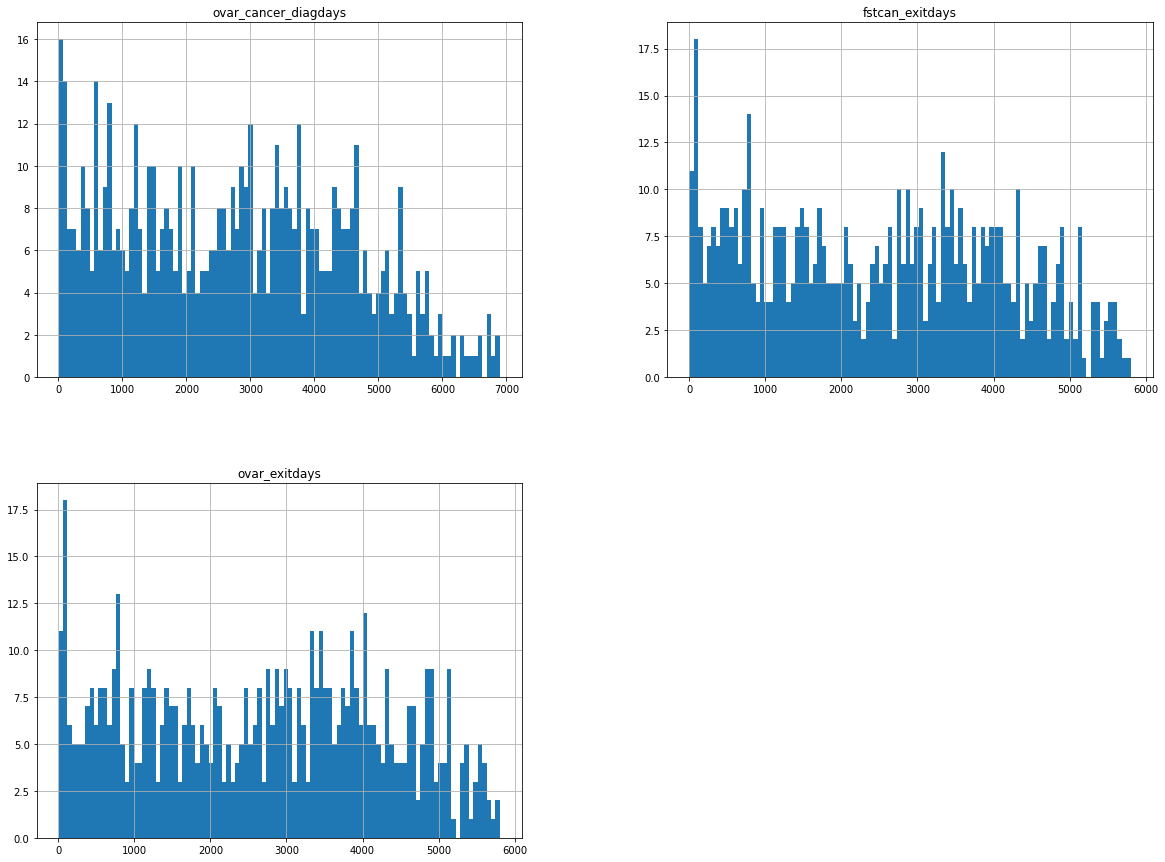

In [229]:
personal_data_cancer[['plco_id', 'ovar_cancer_diagdays', 'fstcan_exitdays', 'ovar_exitdays']].hist(figsize=(20,15), bins=100);

In [230]:
def merge_df_into_features(sourse_df, on_col, variable_col, join='outer'):
    merged_df = None
    for val in sorted(sourse_df[variable_col].unique()):
        df = sourse_df[sourse_df[variable_col] == val]
        cols = df.columns
        cols_dict = {}
        for col in cols:
            if col not in [on_col]:
                cols_dict[col] = f'{col}_{variable_col}_{val}'
        df = df.rename(columns=cols_dict)
        # Get unique IDs
        if merged_df is None:
            merged_df = df
        else:
            merged_df = merged_df.merge(df, on=on_col, how=join)
    return merged_df

# Mean impute before converting into features
screen_data = mean_impute(screen_data, select_numeric_columns(screen_data))
# Turn screen dataset each year into a feature
merged_data_screen = merge_df_into_features(screen_data, 'plco_id', 'study_yr')
print_records_vs_unique(merged_data_screen, 'plco_id', 'merged_data_screen')

Num of records in merged_data_screen dataset: 30849
Num of unique plco_id in merged_data_screen dataset: 30849


In [231]:
# Remove all inad_ and examinerid_ features
inad_cols = [col for col in merged_data_screen.columns if col.startswith('inad_') or col.startswith('examinerid_')]
print(f'Number of inad_ cols: {len(inad_cols)}')
merged_data_screen = merged_data_screen.drop(inad_cols, axis=1)
# Remove features that are 100% missing
merged_data_screen_missing_value = get_missing_values_cols(merged_data_screen)
merged_data_screen_missing_value_100 = merged_data_screen_missing_value[merged_data_screen_missing_value.percent_missing == 100]
print(merged_data_screen_missing_value_100.describe().T)
print(merged_data_screen_missing_value_100['column_name'].to_list())
# drop completely missing columns
merged_data_screen = merged_data_screen.drop(merged_data_screen_missing_value_100['column_name'].to_list(), axis=1)
# Drop all object features
object_cols = [col for col in merged_data_screen.select_dtypes(include=object).columns if col != 'plco_id']
merged_data_screen = merged_data_screen.drop(object_cols, axis=1)
# Mean impute after converting into features
merged_data_screen = mean_impute(merged_data_screen, select_numeric_columns(merged_data_screen))

Number of inad_ cols: 294
                 count   mean  std    min    25%    50%    75%    max
percent_missing    6.0  100.0  0.0  100.0  100.0  100.0  100.0  100.0
['tvures_qvis3_study_yr_5', 'tvures_qvis3_study_yr_4', 'tvures_qvis3_study_yr_3', 'tvures_qvis3_study_yr_0', 'tvures_qvis3_study_yr_1', 'tvures_qvis3_study_yr_2']


In [232]:
merged_data_screen_missing_value = get_missing_values_cols(merged_data_screen)
merged_data_screen_missing_value_100 = merged_data_screen_missing_value[merged_data_screen_missing_value.percent_missing >= 90]

In [233]:
merged_data_screen_missing_value_100.describe().T

,count,mean,std,min,25%,50%,75%,max
percent_missing,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [234]:
print_records_vs_unique_for(screen_abnorm_data, 'plco_id', 'screen_abnorm_data', 'study_yr')

Num of records in screen_abnorm_data dataset: 20186
Num of unique plco_id in screen_abnorm_data dataset: 6992
Num of records in screen_abnorm_data.study_yr=0 dataset: 5418
Num of unique plco_id in screen_abnorm_data.study_yr=0 dataset: 3546
Num of records in screen_abnorm_data.study_yr=1 dataset: 5029
Num of unique plco_id in screen_abnorm_data.study_yr=1 dataset: 3305
Num of records in screen_abnorm_data.study_yr=2 dataset: 4902
Num of unique plco_id in screen_abnorm_data.study_yr=2 dataset: 3117
Num of records in screen_abnorm_data.study_yr=3 dataset: 4837
Num of unique plco_id in screen_abnorm_data.study_yr=3 dataset: 2959


In [235]:
# Drop not useful cols and convert categorical into numerical in screen abnormalities
screen_abnorm_data = screen_abnorm_data.drop('build', axis=1)
# Mean Impute before converting into new features
screen_abnorm_data = mean_impute(screen_abnorm_data, select_numeric_columns(screen_abnorm_data))

In [236]:
# Turn screen abnormalities dataset each year into a feature
merged_df = pd.DataFrame(screen_abnorm_data['plco_id'].unique(), columns=['plco_id'])
sourse_df = screen_abnorm_data
count = 0
for val_1 in sorted(sourse_df['study_yr'].unique()):
    for val_2 in sorted(sourse_df['side'].unique()):
        for val_3 in sorted(sourse_df['source'].unique()):
            for val_4 in sorted(sourse_df['VISIT'].unique()):
                for val_5 in sorted(sourse_df['sbcd'].unique()):
                    df = sourse_df[(sourse_df['study_yr'] == val_1) & (sourse_df['side'] == val_2) & (sourse_df['source'] == val_3) & (sourse_df['VISIT'] == val_4) & (sourse_df['sbcd'] == val_5)]
                    # df = df.drop(['study_yr', 'side', 'source', 'VISIT', 'sbcd'], axis=1)
                    cols = df.columns
                    cols_dict = {}
                    for col in cols:
                        if col not in ['plco_id']:
                            cols_dict[col] = f'{col}_study_yr_{val_1}_side_{val_2}_source_{val_3}_VISIT_{val_4}_sbcd_{val_5}'
                    df = df.rename(columns=cols_dict)
                    # Get unique IDs
                    merged_df = merged_df.merge(df, on='plco_id', how='left')
merged_data_screen_abd = merged_df
print_records_vs_unique(merged_data_screen_abd, 'plco_id', 'screen_abnorm_data')

Num of records in screen_abnorm_data dataset: 6992
Num of unique plco_id in screen_abnorm_data dataset: 6992


In [237]:

# Remove features that are 100% missing
merged_data_screen_abd_missing_value = get_missing_values_cols(merged_data_screen_abd)
merged_data_screen_abd_missing_value_100 = merged_data_screen_abd_missing_value[merged_data_screen_abd_missing_value.percent_missing == 100]
# print(merged_data_screen_abd_missing_value_100.describe().T)
# print(merged_data_screen_abd_missing_value_100['column_name'].to_list())
# drop completely missing columns
merged_data_screen_abd = merged_data_screen_abd.drop(merged_data_screen_abd_missing_value_100['column_name'].to_list(), axis=1)


merged_data_screen_abd = merged_data_screen_abd.replace({'L': 0, 'R': 1, 'TVU': 0, 'TVQ': 1})
# Mean Impute before converting into new features
merged_data_screen_abd = mean_impute(merged_data_screen_abd, select_numeric_columns(merged_data_screen_abd))


# screen_abnorm_data['side'] = screen_abnorm_data['side'].replace({'L': 0, 'R': 1})
# screen_abnorm_data['source'] = screen_abnorm_data['source'].replace({'TVU': 0, 'TVQ': 1})

In [238]:
merged_data_screen_abd

,plco_id,VISIT_study_yr_0_side_L_source_TVQ_VISIT_1_sbcd_1,side_study_yr_0_side_L_source_TVQ_VISIT_1_sbcd_1,sbcd_study_yr_0_side_L_source_TVQ_VISIT_1_sbcd_1,study_yr_study_yr_0_side_L_source_TVQ_VISIT_1_sbcd_1,source_study_yr_0_side_L_source_TVQ_VISIT_1_sbcd_1,solid_study_yr_0_side_L_source_TVQ_VISIT_1_sbcd_1,sepst_study_yr_0_side_L_source_TVQ_VISIT_1_sbcd_1,cyst_study_yr_0_side_L_source_TVQ_VISIT_1_sbcd_1,cystw_study_yr_0_side_L_source_TVQ_VISIT_1_sbcd_1,...,source_study_yr_3_side_R_source_TVU_VISIT_2_sbcd_3,solid_study_yr_3_side_R_source_TVU_VISIT_2_sbcd_3,sepst_study_yr_3_side_R_source_TVU_VISIT_2_sbcd_3,cyst_study_yr_3_side_R_source_TVU_VISIT_2_sbcd_3,cystw_study_yr_3_side_R_source_TVU_VISIT_2_sbcd_3,echo_study_yr_3_side_R_source_TVU_VISIT_2_sbcd_3,maxdi_study_yr_3_side_R_source_TVU_VISIT_2_sbcd_3,volum_study_yr_3_side_R_source_TVU_VISIT_2_sbcd_3,build_cancers_study_yr_3_side_R_source_TVU_VISIT_2_sbcd_3,build_incidence_cutoff_study_yr_3_side_R_source_TVU_VISIT_2_sbcd_3
0,A-004796-1,1.0,0.0,1.0,0.0,1.0,0.115646,0.096872,1.117563,1.020671,...,0.0,0.0,0.0,1.0,1.0,1.0,1.3,3.425,1.0,1.0
1,A-005777-0,1.0,0.0,1.0,0.0,1.0,0.115646,0.096872,1.117563,1.020671,...,0.0,0.0,0.0,1.0,1.0,1.0,1.3,3.425,1.0,1.0
2,A-005948-7,1.0,0.0,1.0,0.0,1.0,0.115646,0.096872,1.117563,1.020671,...,0.0,0.0,0.0,1.0,1.0,1.0,1.3,3.425,1.0,1.0
3,A-006569-0,1.0,0.0,1.0,0.0,1.0,0.115646,0.096872,1.117563,1.020671,...,0.0,0.0,0.0,1.0,1.0,1.0,1.3,3.425,1.0,1.0
4,A-006578-1,1.0,0.0,1.0,0.0,1.0,0.115646,0.096872,1.117563,1.020671,...,0.0,0.0,0.0,1.0,1.0,1.0,1.3,3.425,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6987,Z-160567-7,1.0,0.0,1.0,0.0,1.0,0.115646,0.096872,1.117563,1.020671,...,0.0,0.0,0.0,1.0,1.0,1.0,1.3,3.425,1.0,1.0
6988,Z-160693-0,1.0,0.0,1.0,0.0,1.0,0.115646,0.096872,1.117563,1.020671,...,0.0,0.0,0.0,1.0,1.0,1.0,1.3,3.425,1.0,1.0
6989,Z-160738-4,1.0,0.0,1.0,0.0,1.0,0.115646,0.096872,1.117563,1.020671,...,0.0,0.0,0.0,1.0,1.0,1.0,1.3,3.425,1.0,1.0
6990,Z-161791-1,1.0,0.0,1.0,0.0,1.0,0.115646,0.096872,1.117563,1.020671,...,0.0,0.0,0.0,1.0,1.0,1.0,1.3,3.425,1.0,1.0


In [239]:
# Drop features that are result of the cancer diagnosis
personal_data_cancer = personal_data_cancer.drop(personal_data_drop_features, axis=1)
personal_data_no_cancer = personal_data_no_cancer.drop(personal_data_drop_features, axis=1)
# Merge cancer patients dataset with screen dataset and see missing values
merged_data_cancer = personal_data_cancer.merge(merged_data_screen, on='plco_id', how='left')
merged_data_cancer = merged_data_cancer.merge(merged_data_screen_abd, on='plco_id', how='left')
merged_data_no_cancer = personal_data_no_cancer.merge(merged_data_screen, on='plco_id', how='left')
merged_data_no_cancer = merged_data_no_cancer.merge(merged_data_screen_abd, on='plco_id', how='left')
# Mean Impute before converting into new features
merged_data_cancer = mean_impute(merged_data_cancer, select_numeric_columns(merged_data_cancer))
merged_data_no_cancer = mean_impute(merged_data_no_cancer, select_numeric_columns(merged_data_no_cancer))

In [240]:
import time
x = pd.concat([merged_data_cancer, merged_data_no_cancer], axis=0)
y = x['ovar_cancer']
x = x.drop(['ovar_cancer', 'plco_id'], axis=1)
oversampling = SMOTE()
x, y = oversampling.fit_resample(x, y)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GaussianNB(),
    XGBClassifier(),
    LogisticRegression(max_iter=200)
]
# Calculate years before cancer
def f_score(X_train, X_test, y_train, y_test, classifiers):
    for clf in classifiers:
        s = time.time()
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        f = f1_score(y_true=y_test,y_pred=y_pred,average="macro")
        e = time.time()
        print(f"Score: {round(f,3)} \t Time(in secs): {round(e-s,3)} \t Classifier: {clf.__class__.__name__}")

In [241]:
# drop non-informative features
# x = x.drop(['ph_ovar_muq','orem_fyro'], axis=1)

In [242]:
# x = x.reset_index()
# y = y.reset_index()

In [243]:
f_score(X_train, X_test, y_train, y_test, classifiers)

Score: 1.0 	 Time(in secs): 6.7 	 Classifier: DecisionTreeClassifier
Score: 1.0 	 Time(in secs): 17.867 	 Classifier: RandomForestClassifier
Score: 0.963 	 Time(in secs): 4.82 	 Classifier: GaussianNB
Score: 1.0 	 Time(in secs): 35.659 	 Classifier: XGBClassifier
Score: 0.969 	 Time(in secs): 31.021 	 Classifier: LogisticRegression


c:\Users\fedor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [244]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155192 entries, 0 to 155191
Columns: 1853 entries, ovar_exitstat to build_incidence_cutoff_study_yr_3_side_R_source_TVU_VISIT_2_sbcd_3
dtypes: float64(1806), int64(47)
memory usage: 2.1 GB


In [245]:
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2, f_classif

In [246]:


sel = SelectFromModel(XGBClassifier())
sel.fit(x,y)

SelectFromModel(estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None,
                                        early_stopping_rounds=None,
                                        enable_categorical=False,
                                        eval_metric=None, feature_types=None,
                                        gamma=None, gpu_id=None,
                                        grow_policy=None, importance_type=None,
                                        interaction_constraints=None,
                                        learning_rate=None, max_bin=None,
                                        max_cat_threshold=None,
                                        max_cat_to_onehot=None,
                                        max_delta_step=None, max_depth=None,
                                        max_leaves=None, min_child_weight=None,
                                        missing=nan, monotone_constraints=None,
                                        n_estimators=100, n_jobs=None,
                                        num_parallel_tree=None, predictor=None,
                                        random_state=None, ...))

In [247]:
features = x.columns[(sel.get_support())]
print(len(features))
features

9


Index(['orem_fyro', 'ph_ovar_muq',
       'sepst_study_yr_0_side_L_source_TVQ_VISIT_1_sbcd_2',
       'maxdi_study_yr_0_side_L_source_TVQ_VISIT_2_sbcd_1',
       'cystw_study_yr_1_side_L_source_TVU_VISIT_1_sbcd_1',
       'volum_study_yr_2_side_L_source_TVU_VISIT_1_sbcd_1',
       'echo_study_yr_2_side_L_source_TVU_VISIT_2_sbcd_1',
       'maxdi_study_yr_2_side_L_source_TVU_VISIT_2_sbcd_1',
       'maxdi_study_yr_3_side_L_source_TVU_VISIT_1_sbcd_1'],
      dtype='object')

In [249]:
# configure to select all features
fs = SelectKBest(score_func=f_classif, k='all')
# learn relationship from training data
fs.fit(X_train, y_train)
# what are scores for the features
features_scores = pd.DataFrame(x.columns)
features_scores['scores'] = fs.scores_
features_scores = features_scores.sort_values('scores', ascending=False)
features_scores.to_csv('./feature_selection/all_features_new_cols__mean_imputed.csv')

c:\Users\fedor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [   2    3   35   36   37   38  161  193  203  271  272  282  350  351
  361  429  430  440  448  508  509  519  527  553  568  569  570  571
  572  573  580  581  582  583  584  585  586  587  588  598  606  632
  647  648  649  650  651  652  659  660  661  662  663  664  665  666
  667  677  678  679  680  681  689  690  691  692  693  694  695  703
  704  705  706  707  708  709  712  717  718  719  720  721  722  723
  724  725  726  727  728  731  732  733  734  735  736  737  745  746
  747  748  749  750  751  759  760  761  762  763  764  765  773  774
  775  776  777  778  779  787  788  789  790  791  792  793  801  802
  803  804  805  806  807  808  809  810  811  812  815  816  817  818
  819  820  821  822  823  824  825  826  829  830  831  832  833  834
  835  836  837  838  839  840  842  843  844  845  846  847  848  8

GaussianNB
   precision    recall  f1-score  support
0   0.944403  0.983249  0.963435  15462.0
1   0.982665  0.942543  0.962186  15577.0
ROC AUC score: 0.9851347473444371
Accuracy Score: 0.962820967170334


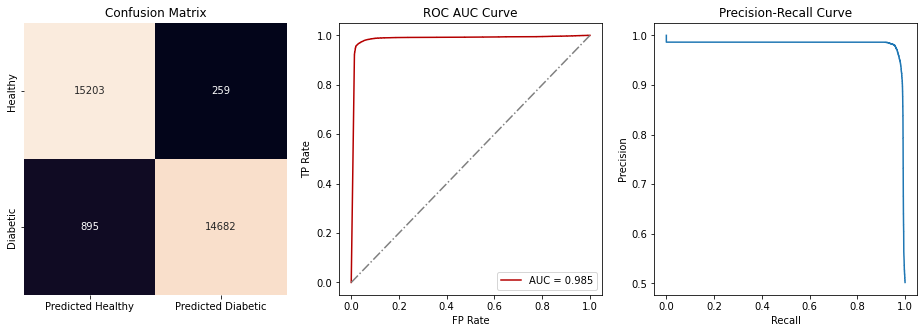

DecisionTreeClassifier
   precision    recall  f1-score  support
0   0.999871  1.000000  0.999935  15462.0
1   1.000000  0.999872  0.999936  15577.0
ROC AUC score: 0.9999358027861591
Accuracy Score: 0.9999355649344374


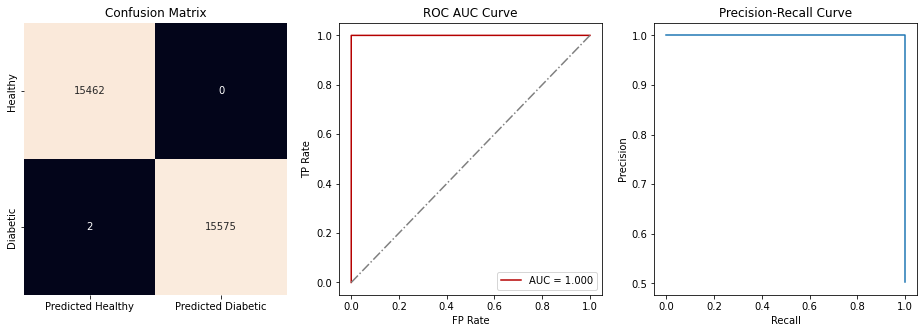

XGBClassifier
   precision    recall  f1-score  support
0   0.999871  1.000000  0.999935  15462.0
1   1.000000  0.999872  0.999936  15577.0
ROC AUC score: 0.9999999418729147
Accuracy Score: 0.9999355649344374


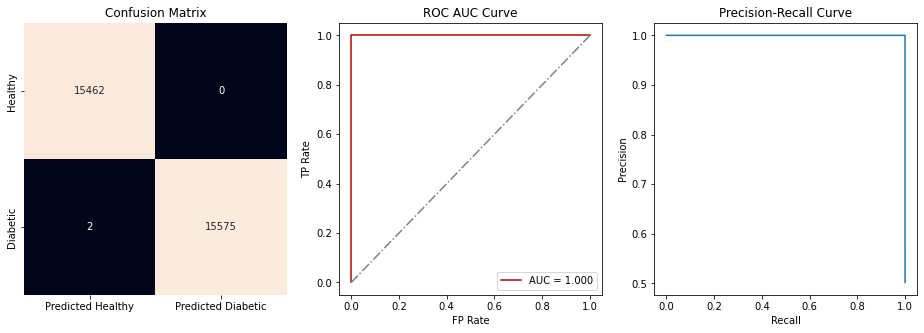

In [250]:
classifiers = {
    # 'LogisticRegression': LogisticRegression(C= 0.25, random_state= 0),
    'GaussianNB': GaussianNB(var_smoothing= 1e-09),
    'DecisionTreeClassifier': DecisionTreeClassifier(criterion= 'entropy', random_state= 0),
    # 'RandomForestClassifier': RandomForestClassifier(criterion= 'gini', n_estimators= 200, random_state= 0),
    'XGBClassifier': XGBClassifier(eval_metric= 'error', learning_rate= 0.1),
    # 'KNeighborsClassifier': KNeighborsClassifier(n_neighbors = 5, p = 2),
}
auc_dict = {}
accuracy_dict = {}
for classifier_type, classifier in classifiers.items():
    print(classifier_type)
    auc, accuracy = run_classifier(classifier, X_train, X_test, y_train, y_test)
    auc_dict[classifier_type] = auc
    accuracy_dict[classifier_type] = accuracy

In [ ]:
# Determine on which features to use mean imputation and on which ones to replace with -1

In [ ]:
# For the screening dataset merge all 'inad_' into 1? 

 The initial dataset had 181 variables (Appendix 1). Variables were ranked by their F-score, which is the harmonic mean of precision and recall, with those with an F-score closest to 1.0 demonstrating high correlation with treatment success [10]. Experts in the treatment of BPH also selected variables for inclusion into the models irrespective of the F-Score, these variables, plus those with a high F-Score were selected for inclusion in initial model development.. The actual variables used by our models were a subset of these, and the number in any given fold and subgroup was dynamically determined by treating this as a hyper-parameter and tuning it as described below.